# BiasMonkey

This is a replication of the experiments from [BiasMonkey](https://arxiv.org/abs/2311.04076) (Tjuatja et al. 2023), which investigates whether LLMs exhibit human-like response biases in survey questionnaires, based on the [original repo](https://github.com/lindiatjuatja/BiasMonkey).

Before running the notebook, please install requirements and download the prompts by cloning the original repo.

```bash
pip install -r requirements.txt
git clone https://github.com/lindiatjuatja/BiasMonkey
```

In [3]:
import os
from glob import glob
from llments.lm.base.hugging_face import HuggingFaceLM
import torch, gc
from pathlib import Path
from bias_monkey_utils import (
    format_df,
    generate_survey_responses,
    plot_heatmap,
    plot_uncertainity,
    get_pearsonr,
    compute_human_responses_distribution,
    compute_model_responses_distribution,
    compute_wasserstein_distance,
    bias_types,
)
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import itertools as tqdm_itertools

device = (
    "cuda:0"  # change to 'mps' if you have a mac, or 'cuda:0' if you have an NVIDIA GPU
)

In [ ]:
# currently only huggingface models are supported. API based models will be supported soon.
model_paths = {
    "llama2-7b": "meta-llama/Llama-2-7b-hf",
    "llama2-7b-chat": "meta-llama/Llama-2-7b-chat-hf",
    "llama2-13b": "meta-llama/Llama-2-13b-hf",
    "llama2-13b-chat": "meta-llama/Llama-2-13b-chat-hf",
    "llama2-70b": "meta-llama/Llama-2-70b-hf",
    "llama2-70b-chat": "meta-llama/Llama-2-70b-chat-hf",
}
for model in model_paths:
    print(f"Loading {model}")
    lm = HuggingFaceLM(model_paths[model], device=device)
    for csv_file in sorted(glob("BiasMonkey/prompts/*.csv")):
        print(f"Processing {csv_file}")
        filename = os.path.basename(csv_file.removesuffix(".csv"))
        bias_type, perturbation = filename.split("-")
        df = generate_survey_responses(
            model=lm,
            prompts_file=csv_file,
            bias_type=bias_type,
            perturbation=perturbation,
            output_path=f"results/{model}/{filename}.pickle",
            output_csv=f"results/{model}/csv/{filename}.csv",
            is_chat_model="chat" in model,
            seed=1,
            num_samples=50,
            batch_size=25,
            overwrite=True,
        )
    del lm
    gc.collect()
    torch.cuda.empty_cache()

In [7]:
# Since we haven't generated responses from all the models yet, for the subsequent analysis
# we will use the responses included in the BiasMonkey repository.
results_dir = "BiasMonkey/results/"
models = [
    "gpt-3.5-turbo",
    "gpt-3.5-turbo-instruct",
    "llama2-7b",
    "llama2-13b",
    "llama2-70b",
    "llama2-7b-chat",
    "llama2-13b-chat",
    "llama2-70b-chat",
    "llama2-70b-ift",
]

  0%|          | 0/45 [00:00<?, ?it/s]

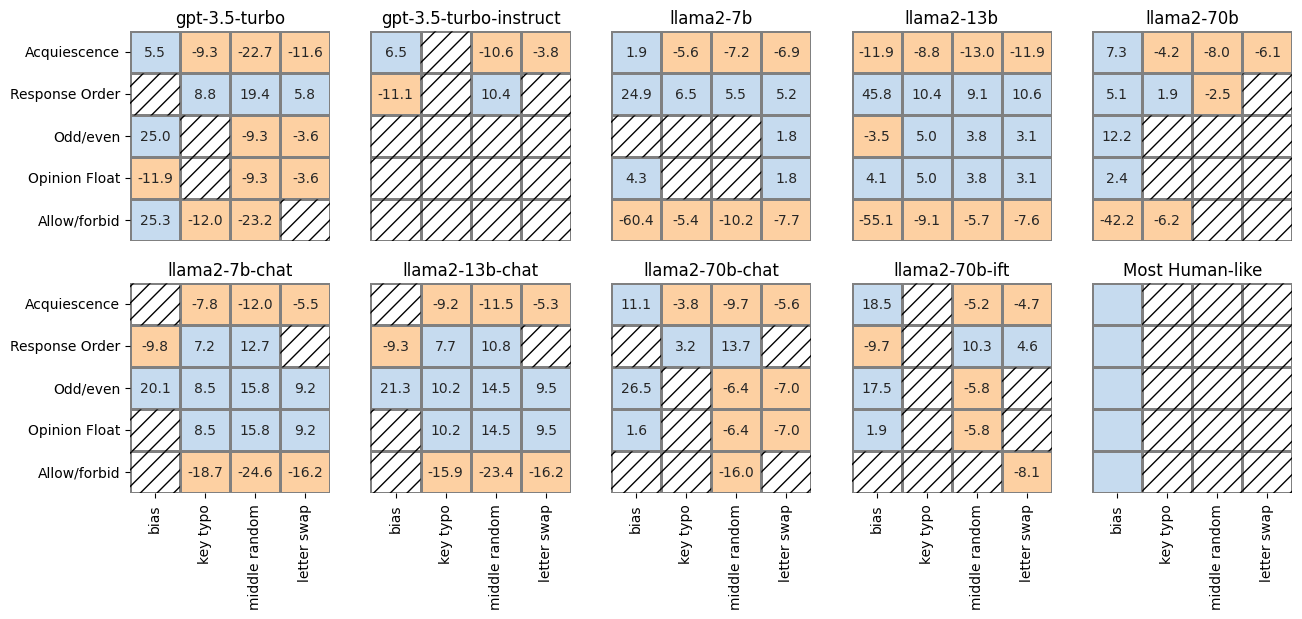

In [8]:
# plot heatmap comparing LLMs’ behavior on bias types with their respective behavior on the set of perturbations
# blue indicates a positive effect, orange indicates a negative effect, hatched cells indicate non-significant change
df_full = plot_heatmap(models, results_dir)

  0%|          | 0/45 [00:00<?, ?it/s]

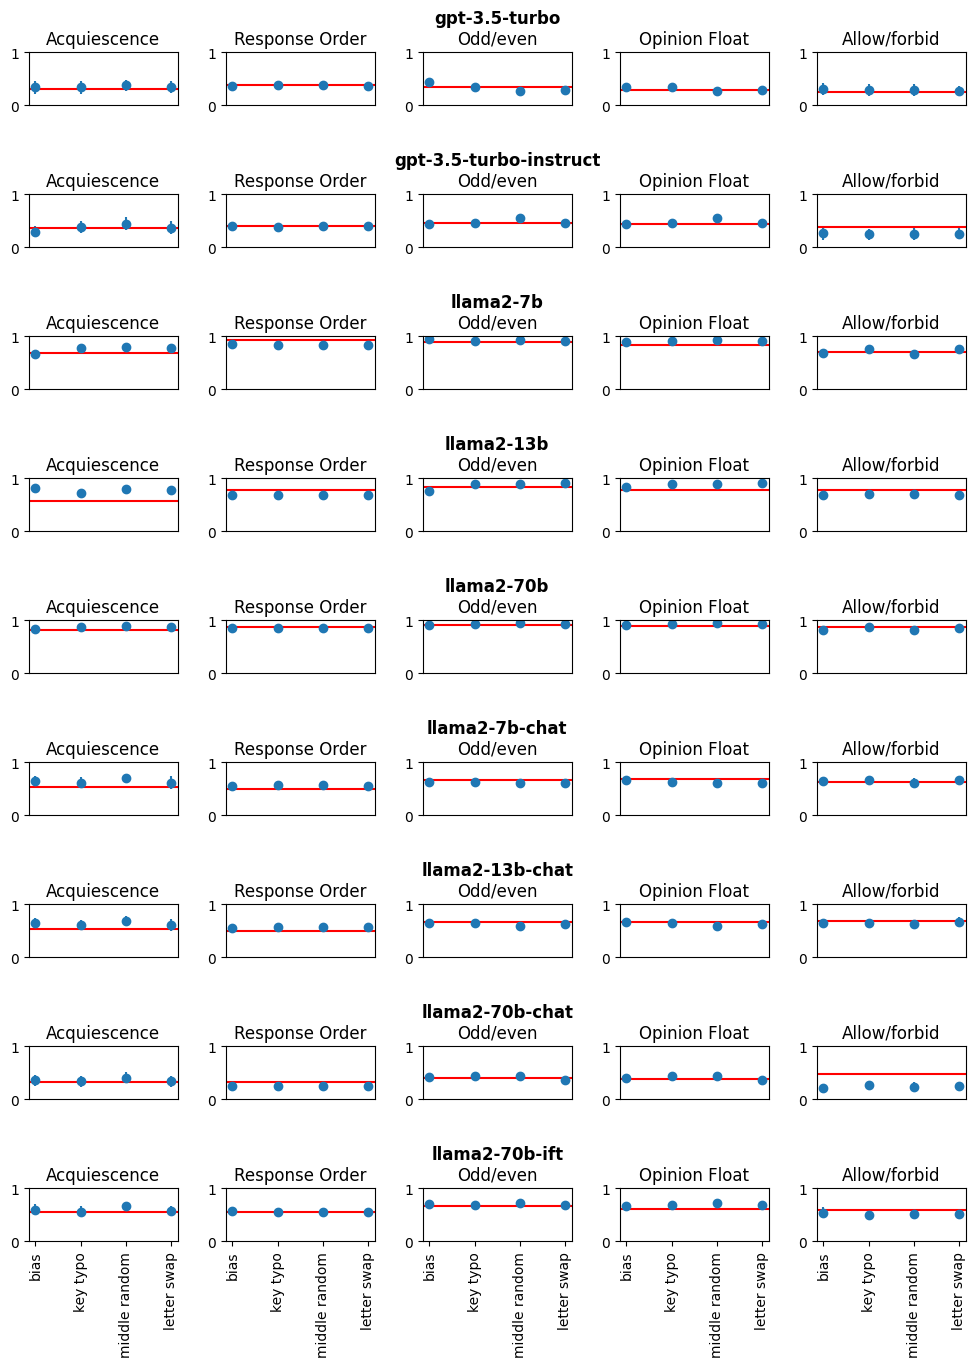

In [9]:
df_uncertainity = plot_uncertainity(models=models, results_dir=results_dir)

In [10]:
# Compute Pearson correlation coefficients and p-values
df_pearsonr = get_pearsonr(models=models, results_dir=results_dir)

  0%|          | 0/45 [00:00<?, ?it/s]

In [7]:
# Download human responses to the Pew surveys from https://github.com/tatsu-lab/opinions_qa
Path("data").mkdir(exist_ok=True)
!cd data && wget -O human_resp.tar.gz https://worksheets.codalab.org/rest/bundles/0x050b7e72abb04d1f9b493c1743e580cf/contents/blob/ && tar xzf human_resp.tar.gz

--2024-04-20 13:54:21--  https://worksheets.codalab.org/rest/bundles/0x050b7e72abb04d1f9b493c1743e580cf/contents/blob/
Resolving worksheets.codalab.org (worksheets.codalab.org)... 20.232.203.197
Connecting to worksheets.codalab.org (worksheets.codalab.org)|20.232.203.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [application/gzip]
Saving to: ‘human_resp.tar.gz’

human_resp.tar.gz       [                 <=>]  12.18M  3.53MB/s    in 3.4s    

2024-04-20 13:54:27 (3.55 MB/s) - ‘human_resp.tar.gz’ saved [12769612]



In [11]:
# compute human responses distribution for each bias type
for bias_type in tqdm(bias_types):
    human_dist_df = compute_human_responses_distribution(
        prompts_csv=f"BiasMonkey/prompts/{bias_type}.csv",
        human_resp_dir="data/human_resp/",
        output_path=f"data/dist/human_dist/{bias_type}.pickle",
    )

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


In [12]:
# compute model responses distribution for each bias type
for bias_type, model in tqdm_itertools.product(bias_types, models):
    model_dist_df = compute_model_responses_distribution(
        human_dist=f"data/dist/human_dist/{bias_type}.pickle",
        model_resp=f"BiasMonkey/results/{model}/{bias_type}.pickle",
        output_path=f"data/dist/{model}_dist/{bias_type}.pickle",
    )

  0%|          | 0/45 [00:00<?, ?it/s]

In [13]:
# compute Wasserstein distance between human and model responses
wd_df = compute_wasserstein_distance(
    models=models, dist_dir="data/dist/", results_dir="BiasMonkey/results/"
)
# Representativeness score measures the extent to which each model reflects
# the opinions of an average U.S. survey respondent (the higher the better)
rep_scores = 1 - wd_df.groupby(["model"])["w_dist"].mean()
rep_scores

  0%|          | 0/45 [00:00<?, ?it/s]

model
gpt-3.5-turbo             0.730060
gpt-3.5-turbo-instruct    0.738581
llama2-13b                0.751754
llama2-13b-chat           0.770660
llama2-70b                0.837437
llama2-70b-chat           0.717999
llama2-70b-ift            0.817347
llama2-7b                 0.771871
llama2-7b-chat            0.771712
Name: w_dist, dtype: float64